In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context("poster")
sns.set(style="whitegrid", color_codes = False)
from pandas.tools.plotting import scatter_matrix
pd.set_option('display.max_columns', 50)
from scipy.stats import chi2_contingency

#read in data as csv
readmit = pd.read_csv('diabetic_data.csv')

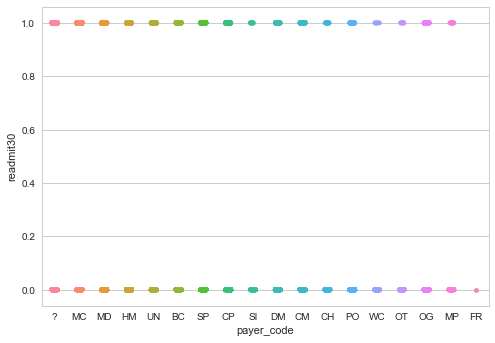

In [3]:
#turn readmission variable into binary (readmitted w/in 30 days or not)
readmit['readmit30'] = np.where(readmit['readmitted'] == '<30', 1, 0)

#Is there an association b/w payer code (52% missing) and readmission?
    #Nothing obvious appears, so remove variable from data set below
sns.stripplot(x = 'payer_code', y = 'readmit30', data = readmit, jitter = True) 

In [4]:
#Is there an association b/w physician specialty (53% missing) and readmission? 
    #sns.stripplot(x = 'medical_specialty', y = 'readmit30', data = readmit, jitter = True) 
    
    #use crosstab and eyeball concordance since above scatterplot is too hard to read
        #nothing obvious appears, so remove variable from data set below
pd.crosstab(index = readmit['medical_specialty'], columns = readmit['readmit30'])

readmit30,0,1
medical_specialty,,
?,44168,5781
AllergyandImmunology,4,3
Anesthesiology,11,1
Anesthesiology-Pediatric,18,1
Cardiology,4927,425
Cardiology-Pediatric,6,1
DCPTEAM,6,0
Dentistry,4,0
Dermatology,1,0


In [5]:
#drop readmitted, weight (92% missing), payer code, and specialty of admitting physician 
    #Weight has too many observations missing to be worth evaluating before dropping.
readmit_drop = readmit.drop(['readmitted', 'weight', 'medical_specialty', 'payer_code'], axis = 1)


In [6]:
#reduce df so that there's one (the first) encounter/patient -- use lowest encounter_id by convention
    #This removes potential bias that could come from having dependent observations.
readmit_sortP = readmit_drop.sort_values(['patient_nbr', 'encounter_id'])
readmit_no_dups = readmit_sortP.drop_duplicates(['patient_nbr'])

#remove bias in outcome variable by dropping encounters that resulted in death or discharge to hospice 
readmit_discharge_clean = readmit_no_dups[((readmit_no_dups.discharge_disposition_id != 11) & 
                                          (readmit_no_dups.discharge_disposition_id != 13) &
                                          (readmit_no_dups.discharge_disposition_id != 14) & 
                                          (readmit_no_dups.discharge_disposition_id != 19) & 
                                          (readmit_no_dups.discharge_disposition_id != 20) & 
                                          (readmit_no_dups.discharge_disposition_id != 21))] 
 #check results
discharge = readmit_discharge_clean.groupby('discharge_disposition_id').size()

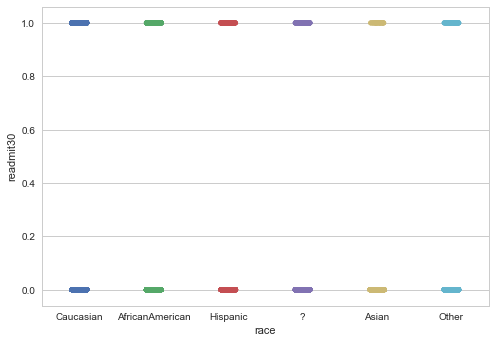

In [7]:
#address missingness in race (3%), diagnosis 3 (<2%), and diagnosis 1 and 2 (both well below 1%)

    #Is there an association b/w race and readmission (outcome variable)?
        #No -- remove race variable below
sns.stripplot(x = 'race', y = 'readmit30', data = readmit_discharge_clean, jitter = True) 

    #remove observations w/ missing race and diagnoses 1, 2, and 3
readmit_full_race = readmit_discharge_clean[((readmit_discharge_clean.race != '?') & 
                                             (readmit_discharge_clean.diag_1 != '?') &
                                             (readmit_discharge_clean.diag_2 != '?') &
                                             (readmit_discharge_clean.diag_3 != '?'))]

In [18]:
#What is the proportion of positive and negative outcomes?
    #6074 1's, 60770 0's 

    #change all remaining ?s to NaN
to_NaN = readmit_full_race.replace('?', np.NaN)
    
    #check for NaN in rows
pd.options.display.max_rows = 75
checkNA = to_NaN.isnull().sum()

    #check for balance in readmission 
y = to_NaN.groupby('readmit30').size()

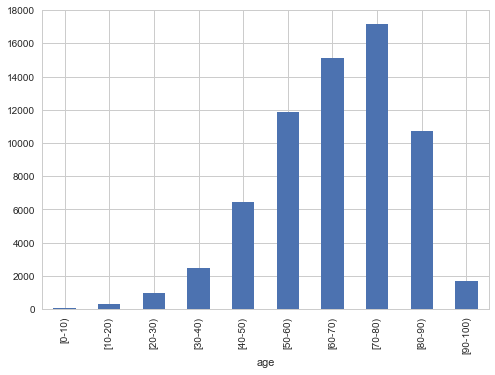

In [19]:
#check variables for association/multicollinearity among independent variables

    #Age is left-skewed. Since we're dealing with patients who skew older, other variables may relate to age. 
age_grouped = to_NaN.groupby(['age']).size()
age_grouped.plot(kind = 'bar')

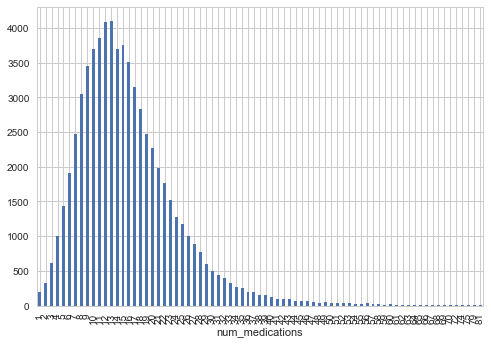

In [20]:
    #Number of medications is right-skewed -- check against age
num_meds = to_NaN.groupby(['num_medications']).size()
num_meds.plot(kind = 'bar') 

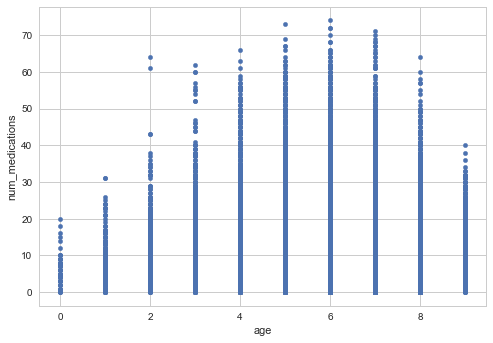

In [21]:
#Is there a correlation b/w age and number of medications? 
    #No, scatter plot below doesn't show any behavior in age.

    #check viability of chi square test for independence -- some expected values too small
pd.crosstab(index = to_NaN['num_medications'], columns = to_NaN['age'])

    #set desired cols to categorical for scatter analysis
to_cats = to_NaN.loc[:,('age', 'num_medications')]

for col in to_cats:
        to_cats[col] = to_cats[col].astype('category')

df_num = to_cats.apply(lambda x: x.cat.codes)
 
    #check age vs. number of medications 
df_num.plot.scatter('age', 'num_medications')

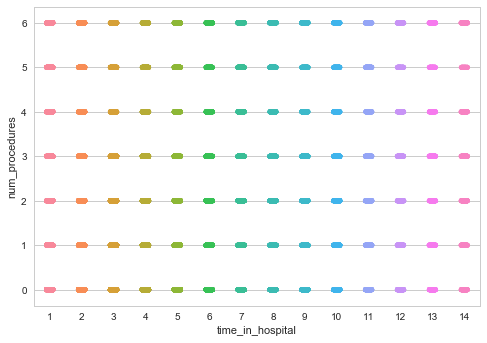

In [22]:
#Is there an association b/w time in hospital vs. number of procedures 
    #No evidence of dependence in scatter plot

sns.stripplot(x = 'time_in_hospital', y = 'num_procedures', data = to_NaN, jitter = True) 

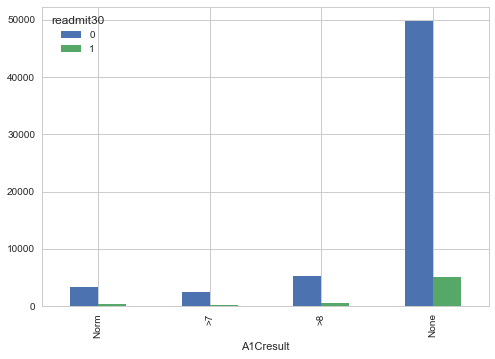

In [23]:
#Is there a relationship b/w test for HbA1c (indep. variable of primary interest) and readmission?
    #No, bar graphs show no evident trends b/w test results and readmission. 

    #create cross-tab for initial evaluation and make df for later bar plot
outcome_ct = pd.crosstab(index = to_NaN['A1Cresult'], columns = to_NaN['readmit30'])
ct_df = pd.DataFrame(outcome_ct.reset_index())

    #make bar chart w/ ordered HbA1c levels
levels = ['Norm', '>7', '>8', 'None']
mapping = {level: i for i, level in enumerate(levels)} #assign nos. to levels based on desired ordinality
key = ct_df['A1Cresult'].map(mapping) #map level ordinals to df rows    
sorting = ct_df.iloc[key.argsort()] #create df w/ desired order from matched ordinals
sorting.plot(kind = 'bar', x = 'A1Cresult')

In [24]:
#Do trends emerge when HbA1c is split into those who had test and who didn't (what original researchers wanted to see)?
    #18.2% of those not readmitted had test done; 17.1% of those readmitted had test done -- pretty balanced  
    #18.1% of all patients had test done -- another indicator of balance

    #create new, binary column to show whether HbA1c test performed or not
to_NaN['HbA1c'] = np.where(to_NaN['A1Cresult'] == 'None', 0, 1)

    #cross tab ofHbA1c test and readmission w/in 30 days 
pd.crosstab(index = to_NaN['HbA1c'], columns = to_NaN['readmit30'], margins = True)

readmit30,0,1,All
HbA1c,,,
0,49718,5033,54751
1,11052,1041,12093
All,60770,6074,66844


In [26]:
#drop created HbA1c variable and write csv for tree-based analysis
ready = to_NaN.drop('HbA1c', axis=1)
ready.to_csv('readmit_for_trees.csv')

In [ ]:
#scrap code for potential use later

 #scatter_matrix(to_NaN[['var1', 'var2', 'var3']])